# Learning Curves and Results

In [1]:
import os
import copy

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms

from tqdm.notebook import trange, tqdm

## All

### baseline-2021-06-09

* SGD(lr=1e-3, **momentum=0.9**)
* SGD(lr=1e-4, **momentum=0.9**)

**Note, by default, momentum=0**

#### Results

* Bayes acc: 1.0
* Train acc: 0.997
* Dev acc:   0.861

#### Bias-Varience

* Bias:      0.00273
* Variance:  0.136

**Bias.** Bias is very low, no need to do anything here.

**Variance.** Need to reduce variance, model is overfitting to the train set.

#### Next Step

Try Adam Optimizer with default momentum parameters, same lr schedule.

### baseline-Adam-2021-06-11

#### Results

* Bayes acc: 1.0
* Train acc: 0.998
* Dev acc:   0.87

#### Bias-Varience

* Bias:      0.00156
* Variance:  0.129

**Bias.** Bias is very low, no need to do anything here.

**Variance.** Need to reduce variance, model is overfitting to the train set.

#### Next Step

Introduce L2 regularisation: weight_decay=1e-08



### Adam_wd=1e-08_2021-06-11

#### Results

* Bayes acc: 1.0
* Train acc: 0.998
* Dev acc:   0.867

#### Bias-Varience

* Bias:      0.00156
* Variance:  0.132

**Bias.** Bias is very low, no need to do anything here.

**Variance.** Need to reduce variance, model is overfitting to the train set.

#### Next Step

Increase L2 regularisation: weight_decay=1e-04

### Adam_wd=0.0001_2021-06-11

#### Results


* Bayes acc: 1.0
* Train acc: 0.998
* Dev acc:   0.869

#### Bias-Varience

* Bias:      0.00156
* Variance:  0.13

**Bias.** Bias is very low, no need to do anything here.

**Variance.** Need to reduce variance, model is overfitting to the train set.

#### Next Step

Increase L2 regularisation: weight_decay=1e-02

### Adam_wd=0.01_2021-06-11

#### Results

* Bayes acc: 1.0
* Train acc: 0.997
* Dev acc:   0.869

#### Bias-Varience

* Bias:      0.00312
* Variance:  0.128

#### Bias-Varience

**Bias.** Bias is very low, no need to do anything here.

**Variance.** Need to reduce variance, model is overfitting to the train set.

#### Next Step

Increase L2 regularisation: weight_decay=1

### Adam_wd=1_2021-06-11

#### Results

* Bayes acc: 1.0
* Train acc: 0.996
* Dev acc:   0.865

#### Bias-Varience

* Bias:      0.00352
* Variance:  0.131

**Bias.** Bias is very low, no need to do anything here.

**Variance.** Need to reduce variance, model is overfitting to the train set.

#### Next Step

Increase L2 regularisation: weight_decay=10

### Adam_wd=10_2021-06-11

#### Results

* Bayes acc: 1.0
* Train acc: 0.939
* Dev acc:   0.857

**Train acc.** Significant drop in performance.

**Dev acc.** Marginal drop in performance.

**Overall.** Weight decay only hurts the train set performance, marginal (negative) effect on the dev set performance.

#### Bias-Varience

* Bias:      0.0605
* Variance:  0.082

**Bias.** Bias increased significantly - maybe we started to underfit

**Variance.** Variance Decreased, but only due to increase in bias.

**Overall.** Weight decay does not seem to help at all.

#### Next Step

Increase L2 regularisation: weight_decay=100

### Adam_wd=100_2021-06-11

#### Results

* Bayes acc: 1.0
* Train acc: 0.762
* Dev acc:   0.764

**Train acc.** Huge drop in performance.

**Dev acc.** Huge drop in performance.

**Overall.** Started to underfit.

#### Bias-Varience

* Bias:      0.238
* Variance:  -0.00234

**Bias.** Bias increased a lot.

**Variance.** Variance is not there anymore.

**Overall.** Started to underfit.

#### Next Step

Use **more aggressive augmentation**. Try w/o weight decay to start with.

## Current

In [25]:
MODEL_NAME = 'Adam_wd=100_2021-06-11'

### Plot and Save Learning Curves

In [26]:
with open(f'../history/{MODEL_NAME}.json') as f:
    history = json.load(f)
    
with open(f'../history/dummy-classifier.json') as f:
    dummy = json.load(f)

In [27]:
dummy

{'loss_w_all_one_half_probs': 2.7725887298583984,
 'train_per_class_accuracies': [0.7953125238418579,
  0.7875000238418579,
  0.7734375,
  0.637499988079071],
 'dev_per_class_accuracies': [0.785937488079071,
  0.7906249761581421,
  0.776562511920929,
  0.6343749761581421],
 'train_average_accuracy': 0.7484375238418579,
 'dev_average_accuracy': 0.7468749284744263}

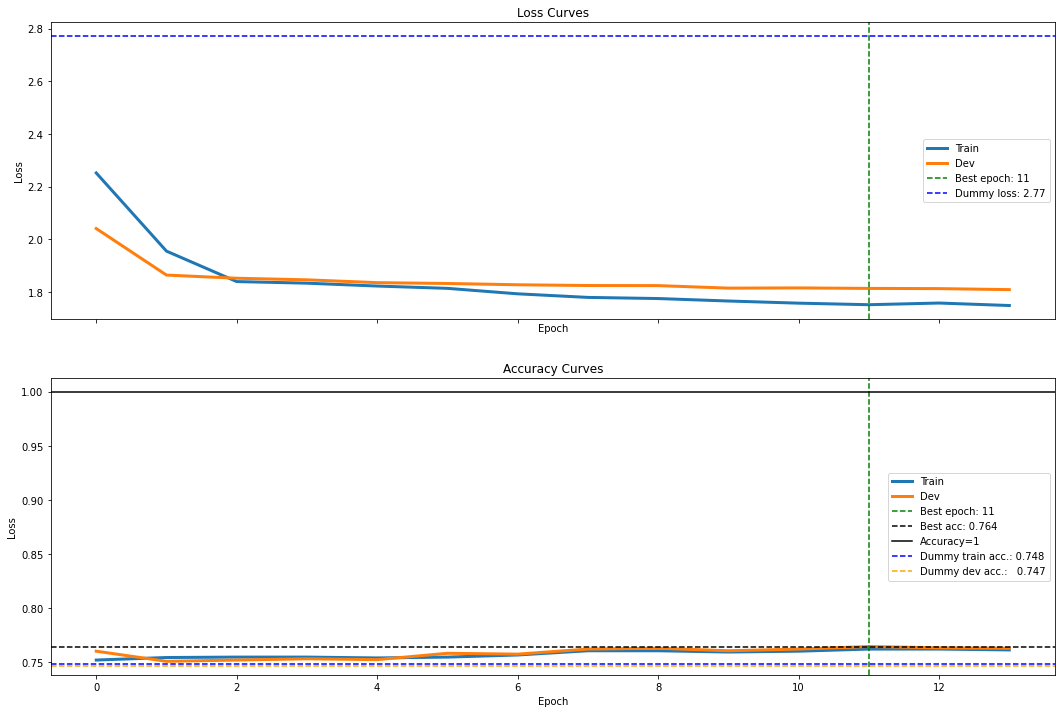

In [28]:
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(18, 12))


ax1.plot(np.arange(len(history['train_losses'])), history['train_losses'], label=f'Train', linewidth=3)
ax1.plot(np.arange(len(history['dev_losses'])), history['dev_losses'], label=f'Dev', linewidth=3)

ax1.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='green', ls='--')
ax1.axhline(y=dummy['loss_w_all_one_half_probs'], label=f"Dummy loss: {dummy['loss_w_all_one_half_probs']:.3}", color='blue', ls='--')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title("Loss Curves")
ax1.legend(loc='best')

ax2.plot(np.arange(len(history['train_average_accuracies'])), history['train_average_accuracies'], label=f'Train', linewidth=3)
ax2.plot(np.arange(len(history['dev_average_accuracies'])), history['dev_average_accuracies'], label=f'Dev', linewidth=3)
ax2.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='green', ls='--')
ax2.axhline(y=history['best_acc'], label=f"Best acc: {history['best_acc']:.3}", color='black', ls='--')
ax2.axhline(y=1, label=f"Accuracy=1", color='black', ls='-')
ax2.axhline(y=dummy['train_average_accuracy'], label=f"Dummy train acc.: {dummy['train_average_accuracy']:.3}", color='blue', ls='--')
ax2.axhline(y=dummy['dev_average_accuracy'], label=f"Dummy dev acc.:   {dummy['dev_average_accuracy']:.3}", color='orange', ls='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title(f"Accuracy Curves")

ax2.legend(loc='best')

plt.savefig(f'../learning_curves/{MODEL_NAME}.png', dpi=300, bbox_inches='tight')
plt.show()

### Results

In [19]:
# sanity check
assert np.max(history['dev_average_accuracies']) == history['best_acc']
assert np.argmax(history['dev_average_accuracies']) == history['best_epoch']

In [20]:
bias = 1 - np.max(history['train_average_accuracies'])
variance = np.max(history['train_average_accuracies']) - history['dev_average_accuracies'][history['best_epoch']]

print(f"* Bayes acc: {1.:.3}")
print(f"* Train acc: {np.max(history['train_average_accuracies']):.3}")
print(f"* Dev acc:   {history['best_acc']:.3}")
print('\n#### Bias-Varience\n')
print(f"* Bias:      {bias:.3}")
print(f"* Variance:  {variance:.3}")

* Bayes acc: 1.0
* Train acc: 0.998
* Dev acc:   0.87

#### Bias-Varience

* Bias:      0.00156
* Variance:  0.129


In [181]:
# # plot losses
# plt.figure(figsize=(18, 9))
# plt.plot(np.arange(len(history['train_losses'])), history['train_losses'], label=f'Train', linewidth=3)
# plt.plot(np.arange(len(history['dev_losses'])), history['dev_losses'], label=f'Dev', linewidth=3)
# plt.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='red', ls='--')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title("Loss Curves")
# plt.legend(loc='best')
# plt.show()

In [182]:
# # plot accuracies
# plt.figure(figsize=(18, 9))
# plt.plot(np.arange(len(history['train_average_accuracies'])), history['train_average_accuracies'], label=f'Train', linewidth=3)
# plt.plot(np.arange(len(history['dev_average_accuracies'])), history['dev_average_accuracies'], label=f'Dev', linewidth=3)
# plt.axvline(x=history['best_epoch'], label=f"Best epoch: {history['best_epoch']}", color='red', ls='--')
# plt.axhline(y=history['best_acc'], label=f"Best acc: {history['best_acc']:.3}", color='black', ls='--')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title(f"Accuracy Curves")
# plt.legend(loc='best')
# plt.show()